# Spatial plots of tas/pr post Krakatoa eruption using CMIP6 historical model output
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files, calculates anomalies and generates spatial plots at different times over Australia.  


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

46 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/tas/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gr1.5/v20190919/*.nc
Model MPI-ESM1-2-HR has different time so is now removed
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/tas/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/tas/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190818/*.nc
BCC-ESM1 

In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

45 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/pr/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/pr/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p

In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,9.35 GB,228.10 MB
Shape,"(41, 1980, 120, 240)","(1, 1980, 120, 240)"
Count,333 Tasks,41 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,18.70 GB,456.19 MB
Shape,"(41, 1980, 120, 240)","(1, 1980, 120, 240)"
Count,382 Tasks,41 Chunks
Type,float64,numpy.ndarray


In [10]:
# # # get rid of new model
# models = models.drop_sel(model=['TaiESM1'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print(models.model.data)

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CIESM' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-Veg-LR' 'FGOALS-f3-L'
 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'GFDL-ESM4' 'GISS-E2-1-G'
 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR'
 'KACE-1-0-G' 'MIROC6' 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0'
 'NESM3' 'NorCPM1' 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out time around Krakatoa eruption

In [12]:
models = models.sel(time = slice('1850-01','1900-01'))

## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [14]:
# select out the northern and sourhern hemisphere regions
models_SH = models_w.sel(lat=slice(-90,0))
models_NH = models_w.sel(lat=slice(0,90))


In [15]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

In [16]:
# this is where I use the land mask and select out the continents
models_w_land = models_w.where(landmask.data==1, drop=True)

In [17]:
# here I select the Australia region with a lon,lat box and the Eastern Australia region
models_aus = models_w_land.sel(lat=slice(-50,-10), lon=slice(110,160)) 
models_EAus = models_w_land.sel(lat=slice(-50,-10), lon=slice(140,155))

## Anomalies

In [18]:
# use functions to calculate the monthly and seasonal anomalies for the globe
# global
# monthly
monthly_anom_glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')
# seasonal
seasonal_anom_glob = func.seasonal_anomaly(models_w, '1850-01', '1881-01')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]


In [19]:
# use functions to calculate the monthly and seasonal anomalies for hemispheres
# NH
monthly_anom_NH = func.monthly_anomaly(models_NH, '1850-01', '1881-01')
seasonal_anom_NH = func.seasonal_anomaly(models_NH, '1850-01', '1881-01')
# SH
monthly_anom_SH = func.monthly_anomaly(models_SH, '1850-01', '1881-01')
seasonal_anom_SH = func.seasonal_anomaly(models_SH, '1850-01', '1881-01')


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]


In [20]:
# use functions to calculate the monthly and seasonal anomalies for aus and E aus
# Australia 
monthly_anom_Aus = func.monthly_anomaly(models_aus, '1850-01', '1881-01')
seasonal_anom_Aus = func.seasonal_anomaly(models_aus, '1850-01', '1881-01')

# East Australia
monthly_anom_EA = func.monthly_anomaly(models_EAus, '1850-01', '1881-01')
seasonal_anom_EA = func.seasonal_anomaly(models_EAus, '1850-01', '1881-01')


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]


In [21]:
# calculate the multi model mean 
# monthly
mmm_mon_Glob = monthly_anom_glob.mean(dim='model')
mmm_mon_NH = monthly_anom_NH.mean(dim='model')
mmm_mon_SH = monthly_anom_SH.mean(dim='model')
mmm_mon_Aus = monthly_anom_Aus.mean(dim='model')
mmm_mon_EA = monthly_anom_EA.mean(dim='model')

# seasonal
mmm_seasonal_Glob = seasonal_anom_glob.mean(dim='model')
mmm_seasonal_NH = seasonal_anom_NH.mean(dim='model')
mmm_seasonal_SH = seasonal_anom_SH.mean(dim='model')
mmm_seasonal_Aus = seasonal_anom_Aus.mean(dim='model')
mmm_seasonal_EA = seasonal_anom_EA.mean(dim='model')

In [22]:
# eruption date
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
e_pre3mon = ['1883-05','1902-07', '1962-12', '1982-01', '1991-03']
e_post6mon = ['1884-02', '1903-04', '1963-09', '1982-10', '1991-12']
e_post12mon = ['1884-08','1903-10', '1964-03', '1983-04', '1992-06']
e_post24mon = ['1885-08','1904-10', '1965-03', '1984-04', '1993-06']
e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']
e_post10yrs = ['1893-08','1912-10', '1973-03', '1992-04', '2001-06']

In [23]:
# Zoom in on Krakatoa time period
K_mmm_mon_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_mon_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_mon_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_mon_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [30]:
dataset = K_mmm_mon_EA.sel(time = e_post6mon[0]).pr


## Figures

In [25]:
func2 = reload(func2)

In [26]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0, 'degrees_celcius')

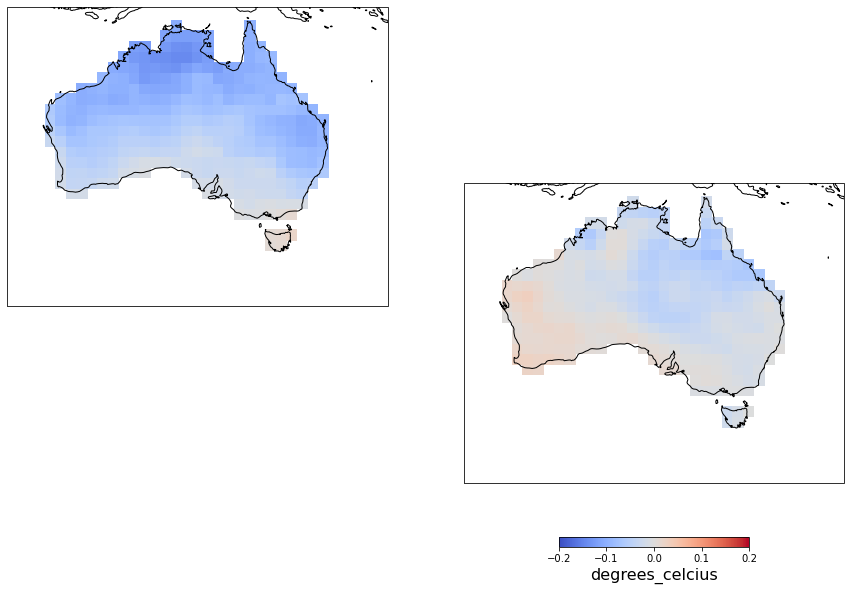

In [27]:
# Spatial plot of temperature anomalies for Krakatoa at different time steps

fig = plt.figure(figsize=(15,20))
axs = []
# spreecify number of columns and rows for the plots
columns = 2
rows = 1
# add a max and min value for the colour bar
vmin = -0.2
vmax = 0.2
    
# Add a subplot with a projection    
ax = fig.add_subplot(rows, columns, 1, projection=ccrs.PlateCarree(180))           
# We'll add a separate colour bar, but make sure all plots share the same min and max colour value       
C = K_mmm_mon_Aus.tas.mean(dim='time').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='coolwarm')    
ax.coastlines() 

# Add a subplot with a projection    
ax = fig.add_subplot(rows, columns, 2, projection=ccrs.PlateCarree(180))           
# We'll add a separate colour bar, but make sure all plots share the same min and max colour value       
C = K_mmm_mon_Aus.pr.mean(dim='time').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='coolwarm')    
ax.coastlines() 


# Gather all axes for when we make the colour bar    
axs.append(ax)    
# Format the colour bar
cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('degrees_celcius', fontsize=16)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'Example of title for subplots')

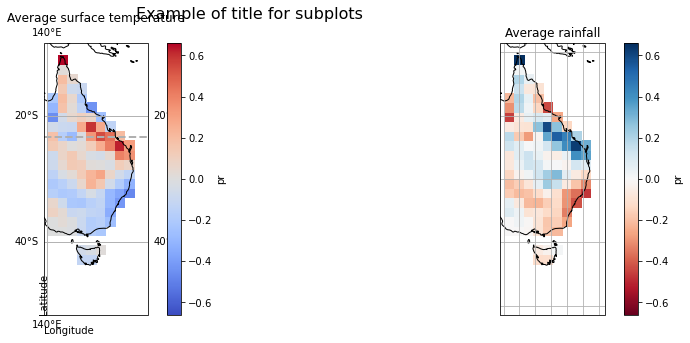

In [31]:
# if you do subplots this way then I can adjust the size of them

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = f.add_subplot(122, projection=ccrs.PlateCarree())

#subplot 1
dataset.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines(resolution='50m')
# add on grid lines for longitude and latitude at specified range and spacing
ax.gridlines(xlocs=range(-180,181,20), ylocs=range(-80,81,20),draw_labels=False) 
ax.gridlines(xlocs=range(-160,181,20), ylocs=range(-80,81,20),draw_labels=True)
# add in different grid lines for tropics
tropics = ax.gridlines(ylocs=[-66.5,-23.43691,23.43691,66.5],draw_labels=False,linewidth=2,linestyle='--', edgecolor='dimgrey')
tropics.xlines=False

# these don't work cos apparently you can't add axis label to subplots so you need to do it manually with text (see below)
ax.set_title('Average surface temperature')
ax.set_ylabel('temperature [C]') # not actually working
ax.set_label('temperature [C]') # not working either

#labels for latitude and longitude
ax.text(0,-0.07,'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.05,0,'Latitude', transform=ax.transAxes, rotation='vertical', va='bottom')

#subplot 2
dataset.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='RdBu')
ax2.coastlines()
ax2.gridlines() # here's how to add gridlines 
ax2.set_title('Average rainfall')

f.set_figheight(5) # these two parameters change the figure height and width 
f.set_figwidth(15)
f.suptitle('Example of title for subplots', fontsize=16)


In [29]:
# # Ruby's graphs 

# fig = plt.figure(figsize=(15,20))
# axs = []columns = 3
# rows = 6
# vmin = 0
# vmax = 14
# for i, m in enumerate(temp_diff.model):    
#     # Add a subplot with a projection    
#     ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))        
#     # Select this model's data and plot it    
#     # We'll add a separate colour bar, but make sure all plots share the same min and max colour value    
#     d = temp_diff.sel(model=m)    
#     C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='Reds')    
#     ax.coastlines()        
#     # Gather all axes for when we make the colour bar    
#     axs.append(ax)    
# Put the colour bar to the left of all axes
# cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
# cbar.ax.set_xlabel('degrees_celcius', fontsize=16)